# Exploratory Data Analysis for Fraud
This notebook provides a Exploratory Data Analysis (EDA) for a fraud detection dataset, with additional analyses designed to prepare the data for machine learning models. It covers the distribution of the target variable, statistical summaries, visualizations for both numerical and categorical features, and time-based trends. Further analyses include multicollinearity detection, target leakage check, and anomaly detection, making the dataset robust and insightful for subsequent modeling.

# Second set of this script is used for data preprocessing
To preprocess this data, we started by handling missing values through mean or mode imputation for numerical features and “Unknown” labels for categorical ones.  We also looked at various methods including dropping columns with excessive missingness. We then encoded categorical features using one-hot encoding for low cardinality and frequency or target encoding for high-cardinality variables to reduce sparsity. Scale numerical features through standardization or log transformation to normalize distributions, especially for skewed data. Finally, we considered dimensionality reduction techniques like PCA and feature selection to streamline the feature set for more efficient modeling.

https://maryville.instructure.com/courses/83764/pages/ieee-fraud-detection?module_item_id=7378399




## Data Import and Setup

In [65]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split



# Set plot style for better visuals
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (5, 3)

In [53]:
# Load the dataset
path_dir = "C:/Users/gpbal/OneDrive/Desktop/capstone_proj/dataset/"
filename_train_id = 'train_identity.csv'
filename_train_trans = 'train_transaction.csv'

try: 
    df_train_id = pd.read_csv(path_dir + filename_train_id)
    df_train_trans = pd.read_csv(path_dir + filename_train_trans)
except Exception as e:
    print("Error reading data:", e)

df = pd.merge(df_train_id, df_train_trans, how='inner',on='TransactionID')

debug_code = 'Y'
if debug_code == 'Y':
    df_train_id = df_train_id.sample(1000)
    df_train_trans = df_train_trans.sample(1000)
    df_sample = df.sample(10000)
    

In [54]:
# Review Sampled Data Set
#df_train_trans.to_csv(path_dir + 'sample_trans_id.csv')
#df_train_id.to_csv(path_dir + 'sample_id_sample.csv')
df_sample.to_csv(path_dir + 'df_sample.csv')
df.to_csv(path_dir + 'df.csv')

#For the sake of expediency, making this sample of dataset for now.
df = df_sample


In [55]:
# Basic Data Information
#This code performs an initial assessment of the dataset. It first outputs the dataset's shape, 
# showing the number of rows and columns, and displays the data types of each column. It then 
# identifies and counts missing values and duplicate entries, followed by printing the first 
# few rows for a quick view of the data structure and contents.

print("Data Shape:", df.shape)




Data Shape: (10000, 434)


In [56]:
print("Data Types:\n", df.dtypes)


Data Types:
 TransactionID      int64
id_01            float64
id_02            float64
id_03            float64
id_04            float64
                  ...   
V335             float64
V336             float64
V337             float64
V338             float64
V339             float64
Length: 434, dtype: object


In [57]:
print("Missing Values:\n", df.isnull().sum())


Missing Values:
 TransactionID       0
id_01               0
id_02             235
id_03            5446
id_04            5446
                 ... 
V335             4354
V336             4354
V337             4354
V338             4354
V339             4354
Length: 434, dtype: int64


In [58]:
# Count null values by column and display as a table
null_counts = pd.DataFrame(df.isnull().sum(), columns=['Null Count'])
null_counts['Null Percentage'] = (df.isnull().mean() * 100).round(2)  # Calculate percentage of nulls
null_counts = null_counts[null_counts['Null Count'] > 0]  # Filter to show only columns with nulls

# Display the table
null_counts.sort_values(by='Null Count', ascending=False)


,Null Count,Null Percentage
V11,10000,100.00
M9,10000,100.00
D11,10000,100.00
V8,10000,100.00
V7,10000,100.00
...,...,...
V109,5,0.05
V108,5,0.05
V106,5,0.05
V105,5,0.05


In [59]:
print("Duplicate Entries:", df.duplicated().sum())


Duplicate Entries: 0


In [60]:
print("First Few Rows:\n", df.head())

First Few Rows:
         TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  \
115851        3434623  -10.0  197876.0    NaN    NaN    0.0    0.0    NaN   
59553         3127214  -10.0  338019.0    NaN    NaN    0.0    0.0    NaN   
3664          3002790  -15.0  242981.0    NaN    NaN    1.0  -21.0    NaN   
45459         3093938   -5.0   49524.0    NaN    NaN    5.0  -22.0    NaN   
128584        3507579    0.0   32826.0    0.0    0.0    3.0    0.0    NaN   

        id_08  id_09  ...  V330  V331  V332  V333  V334 V335 V336  V337  V338  \
115851    NaN    NaN  ...   0.0   0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   
59553     NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   
3664      NaN    NaN  ...   NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN   
45459     NaN    NaN  ...   0.0   0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   
128584    NaN    0.0  ...   0.0  50.0  50.0  50.0   0.0  0.0  0.0   0.0   0.0   

        V339  
115851   0.0  
595

## Data Cleanup

In [61]:
df.dropna(axis=1, how='all', inplace=True)


In [ ]:
import time
from tqdm import tqdm
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

total_start_time = time.time()

# Identify missing data characteristics
basic_imputation_threshold = 0.1  # <10% missing values
advanced_imputation_threshold = 0.5  # >50% missing values

# Separate columns based on missing value percentage and type
basic_impute_cols = []
knn_impute_cols = []
iterative_impute_cols = []

for col in df.columns:
    missing_ratio = df[col].isnull().mean()
    if missing_ratio < basic_imputation_threshold:
        basic_impute_cols.append(col)
    elif missing_ratio > advanced_imputation_threshold and df[col].dtype in ['float64', 'int64']:
        iterative_impute_cols.append(col)
    elif df[col].dtype in ['float64', 'int64']:
        knn_impute_cols.append(col)

# Basic Imputation for Columns with Low Missingness (<10%)
start_time = time.time()
for col in tqdm(basic_impute_cols, desc="Basic Imputation"):
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)  # Mode for categorical data
    else:
        df[col].fillna(df[col].mean(), inplace=True)  # Mean for numerical data
print(f"Basic imputation completed in {time.time() - start_time:.2f} seconds\n")

# KNN Imputation for Numerical Columns with Moderate Missingness (10%-50%)
start_time = time.time()
if knn_impute_cols:
    print("Applying KNN imputation to numerical columns with moderate missingness...")
    knn_imputer = KNNImputer(n_neighbors=5)
    df[knn_impute_cols] = knn_imputer.fit_transform(df[knn_impute_cols])
print(f"KNN imputation completed in {time.time() - start_time:.2f} seconds\n")

# Iterative Imputation for Numerical Columns with High Missingness (>50%)
start_time = time.time()
if iterative_impute_cols:
    print("Applying Iterative Imputation to numerical columns with high missingness...")
    iter_imputer = IterativeImputer(random_state=42)
    
    # Fit and transform the data, then convert to a DataFrame with only the columns that were imputed
    imputed_data = pd.DataFrame(
        iter_imputer.fit_transform(df[iterative_impute_cols]),
        columns=iterative_impute_cols,
        index=df.index
    )
    
    # Assign the imputed data back to the original DataFrame
    df[iterative_impute_cols] = imputed_data

print(f"Iterative imputation completed in {time.time() - start_time:.2f} seconds\n")

# Impute Categorical Columns with Simple Imputer (Most Frequent)
start_time = time.time()
categorical_columns = df.select_dtypes(include=['object']).columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = cat_imputer.fit_transform(df[categorical_columns])
print(f"Categorical imputation completed in {time.time() - start_time:.2f} seconds\n")

print("Data Shape after Cleanup:", df.shape)
print("Any Remaining Missing Values:\n", df.isnull().sum().sum())
print(f"Total cleanup process completed in {time.time() - total_start_time:.2f} seconds")


Basic Imputation: 100%|██████████| 244/244 [00:00<00:00, 975.36it/s]


Basic imputation completed in 0.26 seconds

Applying KNN imputation to numerical columns with moderate missingness...
KNN imputation completed in 81.19 seconds

Applying Iterative Imputation to numerical columns with high missingness...


c:\Users\gpbal\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Iterative imputation completed in 50.42 seconds

Categorical imputation completed in 0.11 seconds

Data Shape after Cleanup: (10000, 413)
Any Remaining Missing Values:
 0
Total cleanup process completed in 132.22 seconds


c:\Users\gpbal\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


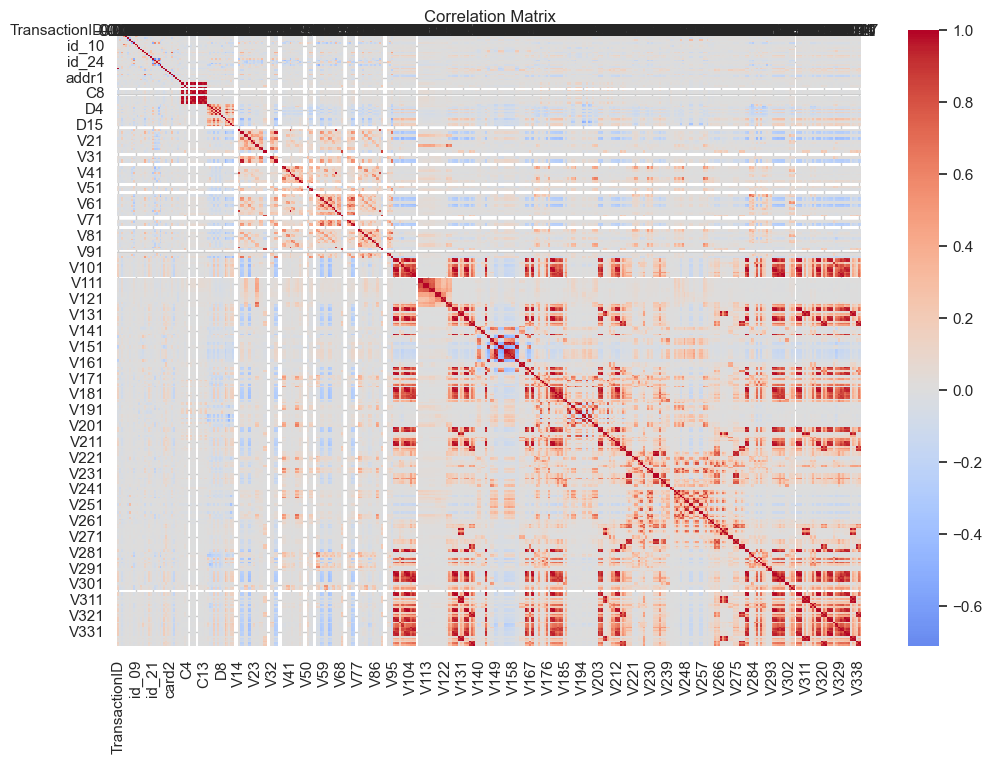

In [29]:
# 8. Correlation Matrix
plt.figure(figsize=(12, 8))
corr_matrix = df[numerical_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()



c:\Users\gpbal\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\gpbal\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Correlation of Numerical Features with Fraud:
 id_01   -0.154886
id_22   -0.101432
D7      -0.098982
D5      -0.095843
D8      -0.086447
           ...   
V76           NaN
V90           NaN
V91           NaN
V107          NaN
V305          NaN
Length: 389, dtype: float64


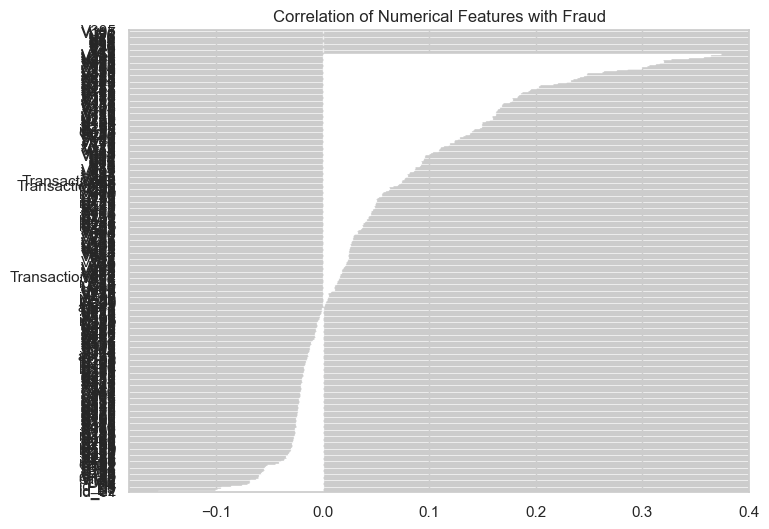

In [ ]:
# Fraud Correlation with Numerical Features
correlations_with_target = df[numerical_columns].corrwith(df[target_column]).sort_values()
print("\nCorrelation of Numerical Features with Fraud:\n", correlations_with_target)

plt.figure(figsize=(8, 6))
correlations_with_target.plot(kind='barh')
plt.title("Correlation of Numerical Features with Fraud")
plt.show()

#

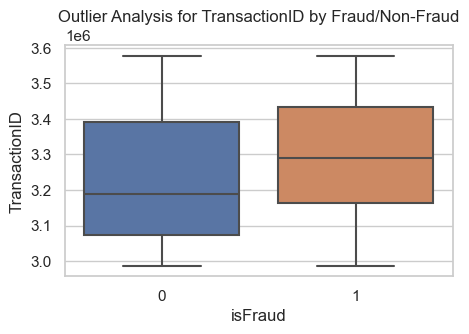

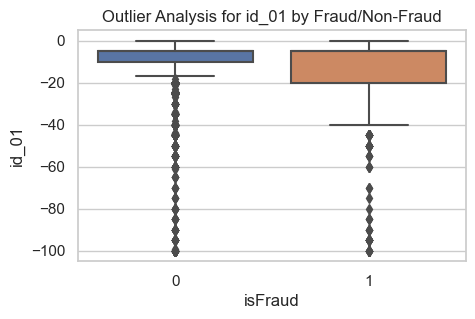

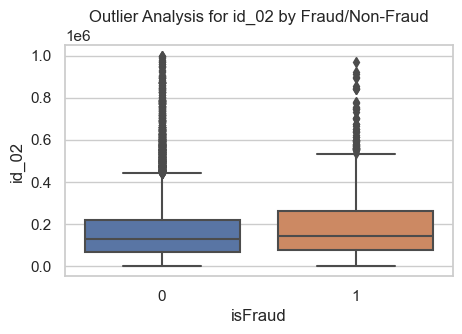

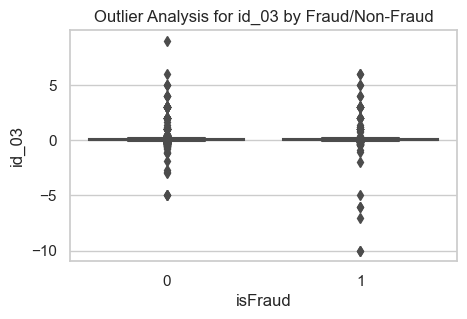

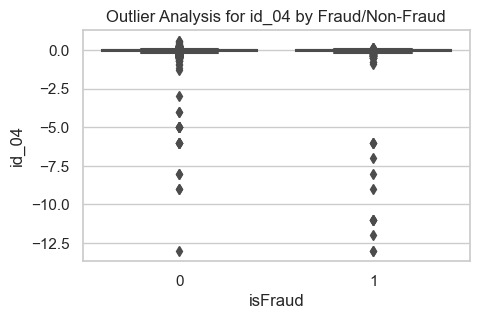

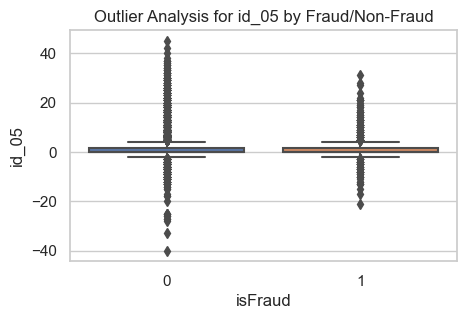

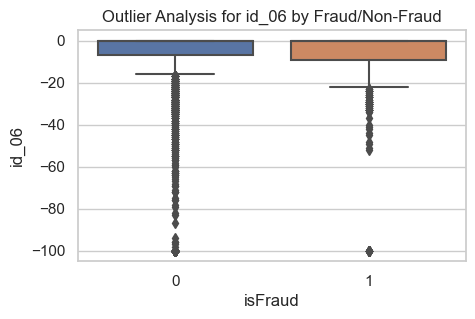

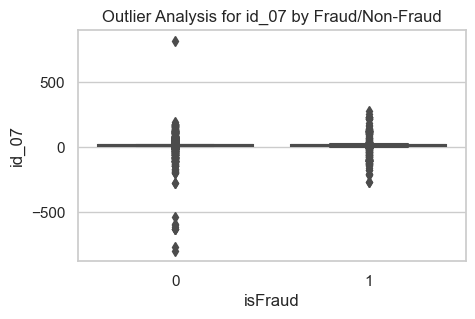

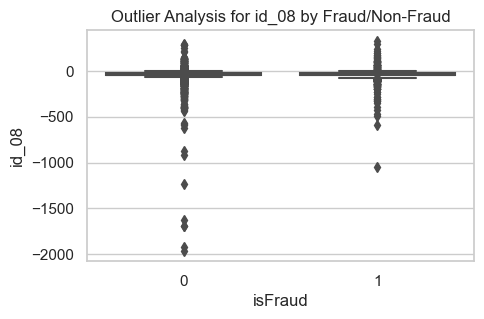

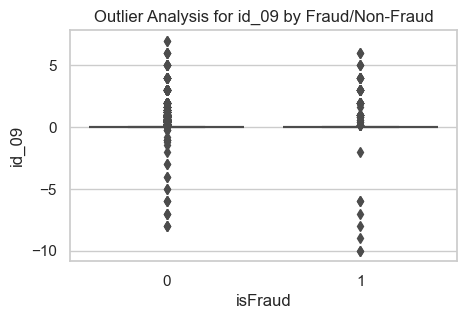

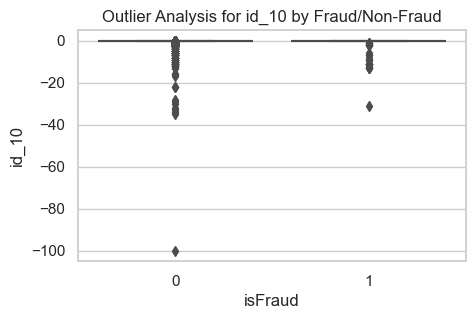

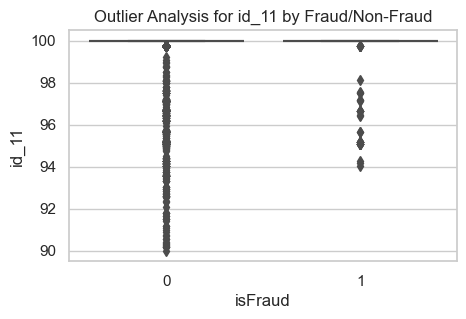

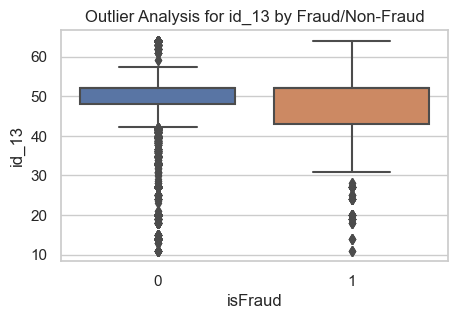

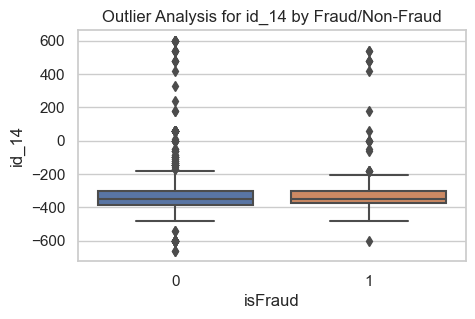

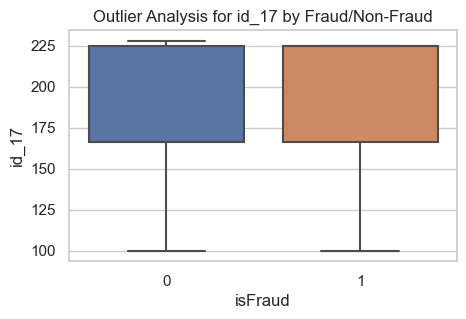

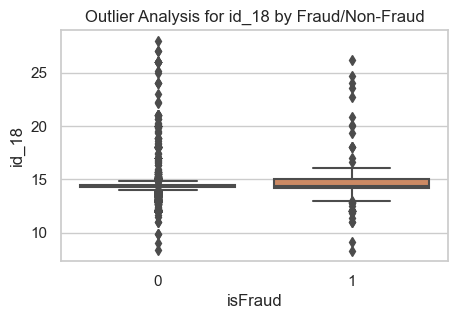

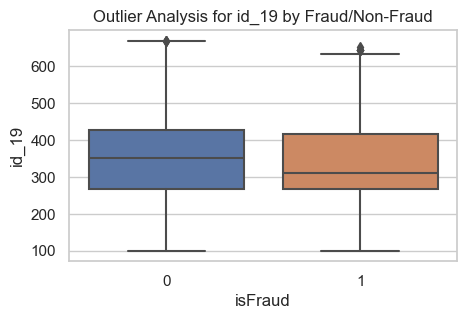

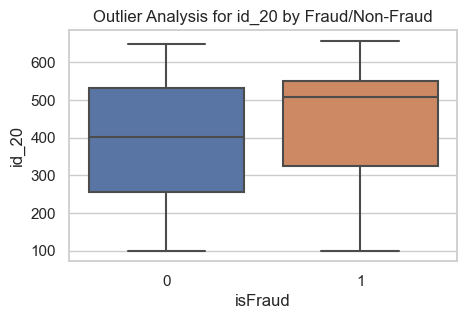

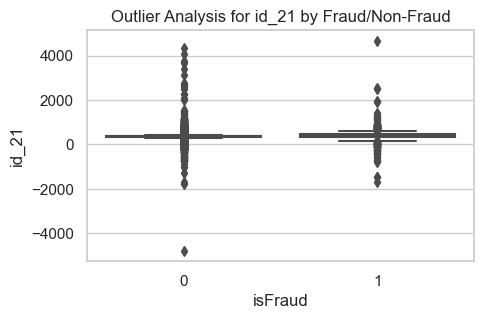

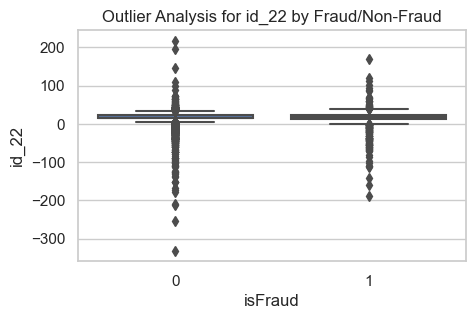

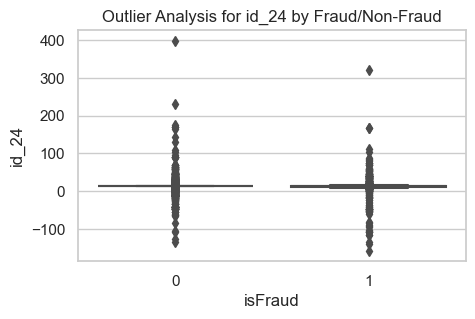

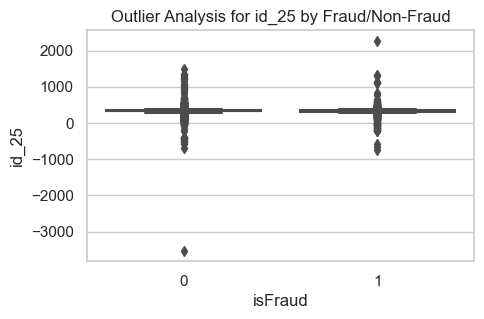

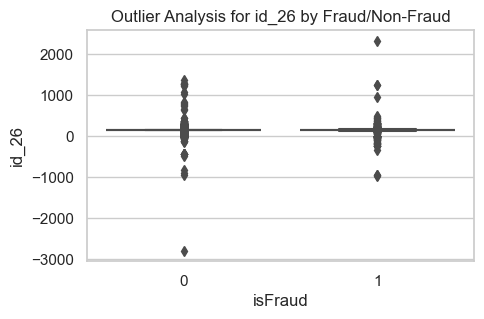

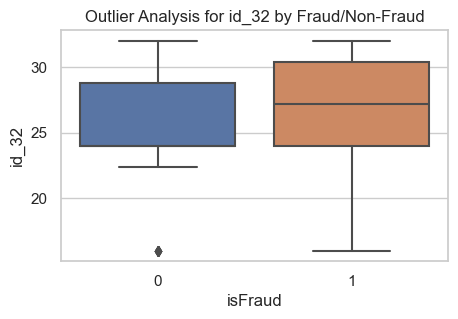

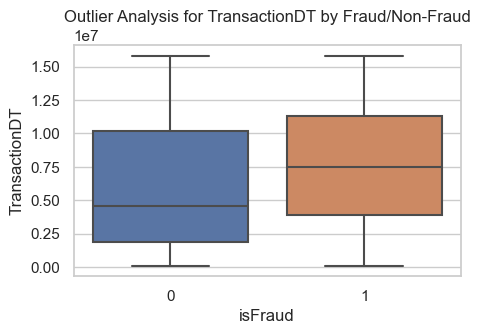

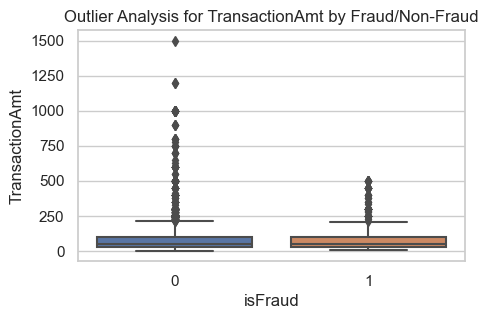

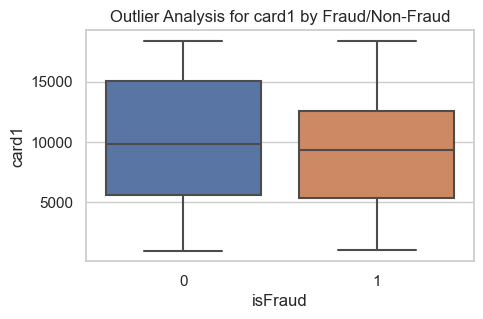

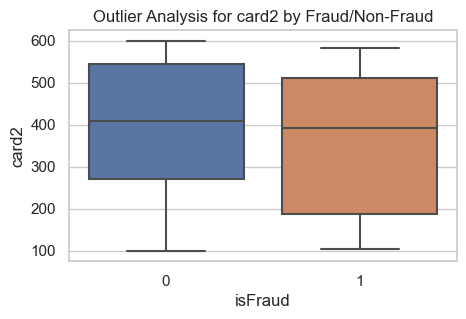

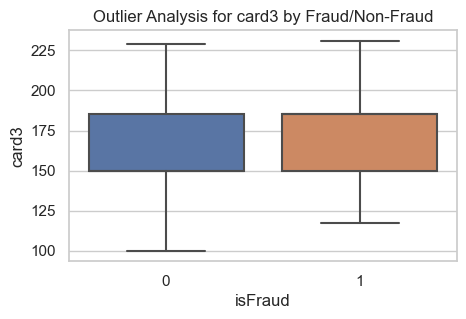

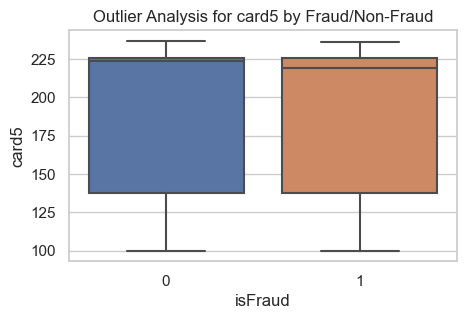

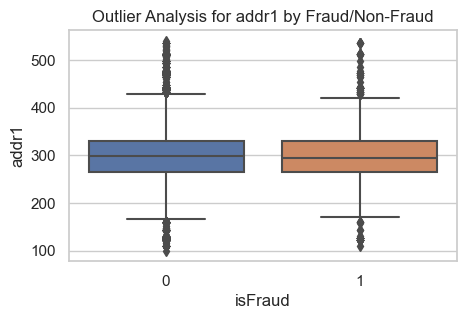

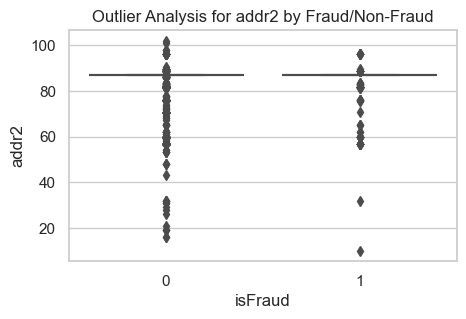

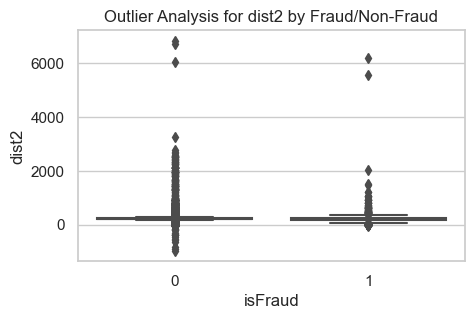

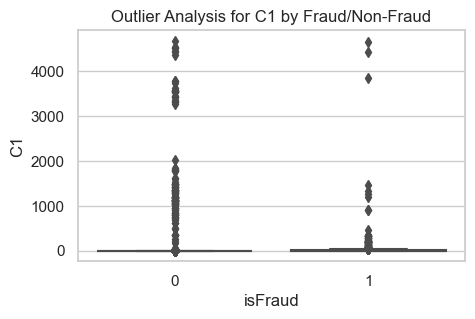

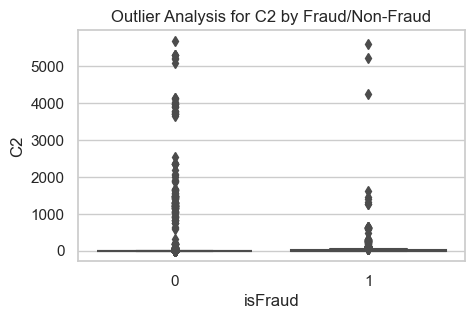

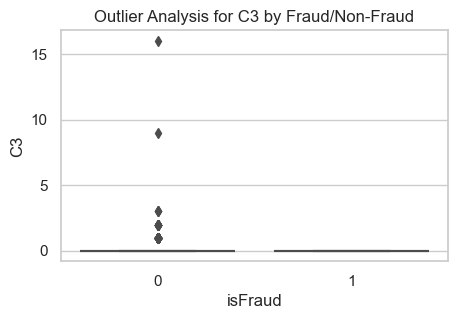

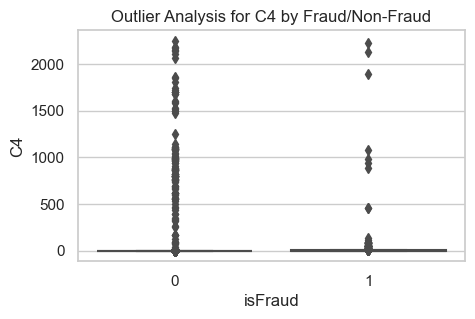

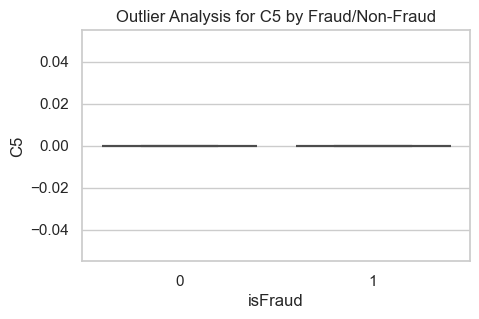

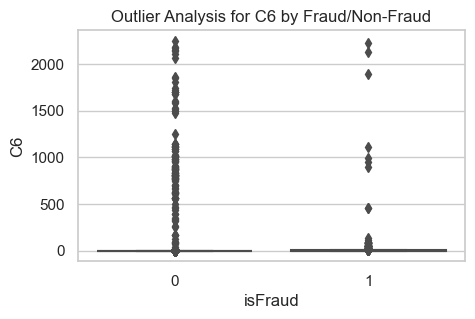

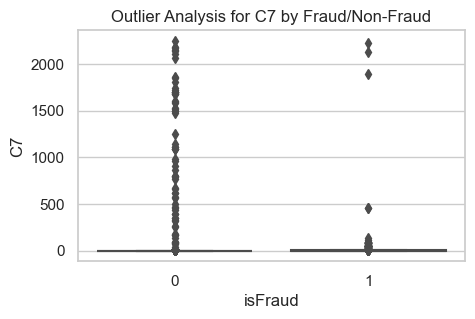

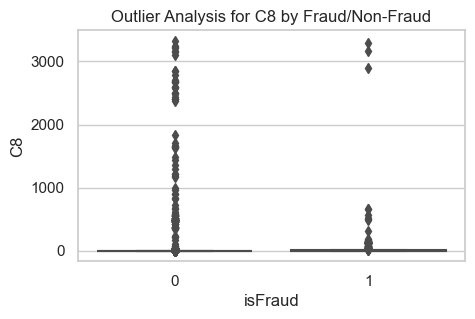

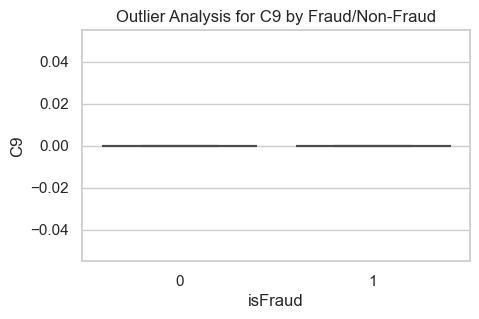

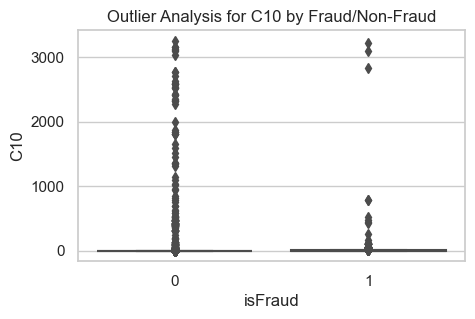

KeyboardInterrupt: 

In [ ]:
# Outlier Detection with Box Plots
for col in numerical_columns:
    plt.figure()
    sns.boxplot(data=df, x=target_column, y=col)
    plt.title(f"Outlier Analysis for {col} by Fraud/Non-Fraud")
    plt.show()


In [ ]:

# Pairplot of Selected Features (Top 10 Correlated with Fraud)
top_10_features = correlations_with_target.abs().sort_values(ascending=False).head(10).index
sns.pairplot(df[top_10_features.union([target_column])], hue=target_column)
plt.suptitle("Pairplot of Top 10 Correlated Features with Fraud", y=1.02)
plt.show()

In [ ]:
# 12. Statistical Tests (Comparing Fraud vs Non-Fraud for Numerical Features)
significant_features = []
for col in numerical_columns:
    fraud_values = df[df[target_column] == 1][col]
    non_fraud_values = df[df[target_column] == 0][col]
    stat, p_value = ttest_ind(fraud_values, non_fraud_values, nan_policy='omit')
    if p_value < 0.05:
        significant_features.append(col)
        print(f"Feature {col} shows significant difference between fraud and non-fraud with p-value: {p_value:.4f}")



In [67]:
print("Features with statistically significant differences:", significant_features)



NameError: name 'significant_features' is not defined

In [ ]:
# Missing Value Imputation Strategy (Optional based on data)
# Impute missing values with median for numerical columns
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].median())

# Encode categorical features for modeling purposes
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

print("\nEDA complete. Data is now ready for further preprocessing and modeling.")


# Additional EDA for Machine Learning Dataset

In [ ]:

# Load dataset
data = df

# Separate features and target
X = df.drop(columns=['isFraud'])  # Replace 'isFraud' with your target column name if different
y = df['isFraud']

# Handle Missing Values
# Separate numerical and categorical features
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Impute numerical features using IterativeImputer for multivariate imputation
num_imputer = IterativeImputer(random_state=0)
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

# Impute categorical features with 'Unknown' for missing values
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

# Encode Categorical Features
# Use One-Hot Encoding for low-cardinality categorical features
low_cardinality_cols = [col for col in categorical_cols if X[col].nunique() < 10]
X = pd.get_dummies(X, columns=low_cardinality_cols, drop_first=True)

# Use Target Encoding for high-cardinality categorical features
high_cardinality_cols = [col for col in categorical_cols if X[col].nunique() >= 10]
target_encoder = TargetEncoder(cols=high_cardinality_cols)
X[high_cardinality_cols] = target_encoder.fit_transform(X[high_cardinality_cols], y)

# Scale Numerical Features
# Standardize numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Apply Power Transformation (log transformation) to reduce skewness in highly skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X[numerical_cols] = power_transformer.fit_transform(X[numerical_cols])

# Dimensionality Reduction
# Apply PCA for dimensionality reduction, retain 95% of the variance
pca = PCA(n_components=0.95, random_state=0)
X_reduced = pca.fit_transform(X)

# Split the data for training and evaluation
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=0)

# The preprocessed data is now ready for model training
print("Data preprocessing complete. Shape of training data:", X_train.shape)


KeyError: 'id_12'

In [ ]:
# Import libraries


# Load dataset
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.drop(target_column)
categorical_columns = df.select_dtypes(include=['object']).columns
timestamp_column = 'timestamp' if 'timestamp' in df.columns else None

# Feature Importance Analysis
# Initial feature importance using RandomForest
X = df.drop(columns=[target_column])
y = df[target_column]
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title("Feature Importance from Random Forest")
plt.show()



ValueError: could not convert string to float: 'NotFound'

In [ ]:
# Multicollinearity Check
# Variance Inflation Factor (VIF) for multicollinearity detection
X_numeric = X.select_dtypes(include=[np.number])
vif_data = pd.DataFrame()
vif_data['Feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print("\nVariance Inflation Factor:\n", vif_data.sort_values(by='VIF', ascending=False))



c:\Users\gpbal\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\gpbal\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\gpbal\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Variance Inflation Factor:
     Feature  VIF
171    V122  inf
169    V120  inf
168    V119  inf
166    V117  inf
162    V113  inf
..      ...  ...
124     V75  NaN
125     V76  NaN
139     V90  NaN
140     V91  NaN
389    hour  NaN

[392 rows x 2 columns]


In [ ]:
# Interaction Analysis
# Pairwise scatter plots for top features
top_features = feature_importance.head(5).index  # Top 5 most important features
sns.pairplot(df[top_features.union([target_column])], hue=target_column)
plt.suptitle("Pairwise Scatter Plots for Top Features", y=1.02)
plt.show()


NameError: name 'feature_importance' is not defined

In [ ]:

# Target Leakage Detection
# Check high correlation with the target that may indicate leakage
correlation_with_target = df[numerical_columns].corrwith(df[target_column]).sort_values(ascending=False)
print("\nHigh Correlation with Target (potential leakage indicators):\n", correlation_with_target[correlation_with_target > 0.7])



High Correlation with Target (potential leakage indicators):
 Series([], dtype: float64)


c:\Users\gpbal\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\gpbal\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


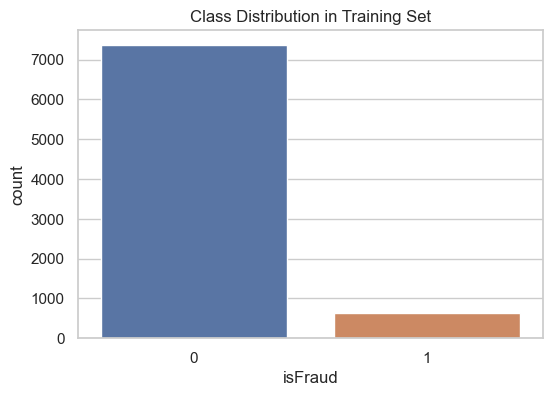

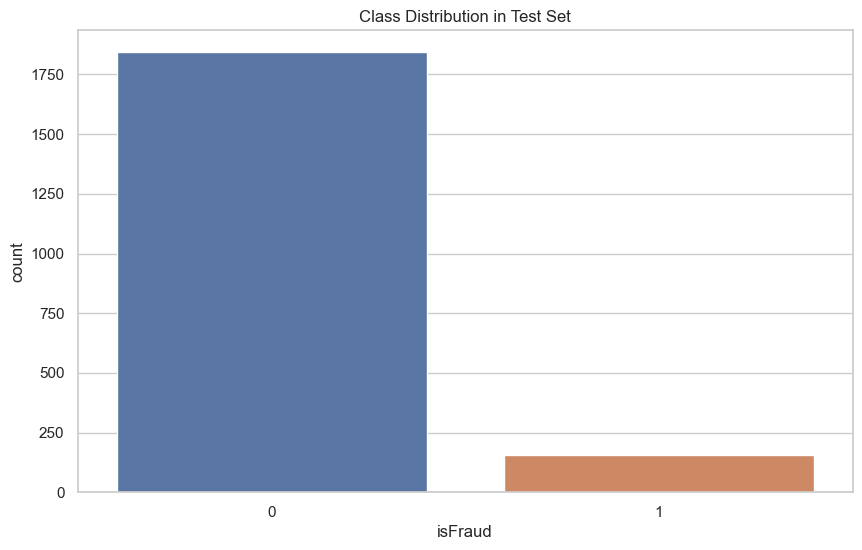

In [ ]:

# Distribution and Balance in Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")
plt.show()
sns.countplot(x=y_test)
plt.title("Class Distribution in Test Set")
plt.show()



In [ ]:
# Anomaly Detection
# Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(X)
plt.figure()
sns.histplot(df['anomaly_score'], bins=20)
plt.title("Anomaly Scores from Isolation Forest")
plt.show()


C:\Users\gpbal\AppData\Local\Temp\ipykernel_6100\3611109702.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_binned'] = pd.qcut(df[col], q=4, duplicates='drop')
c:\Users\gpbal\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\gpbal\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

AttributeError: 'numpy.int64' object has no attribute 'startswith'

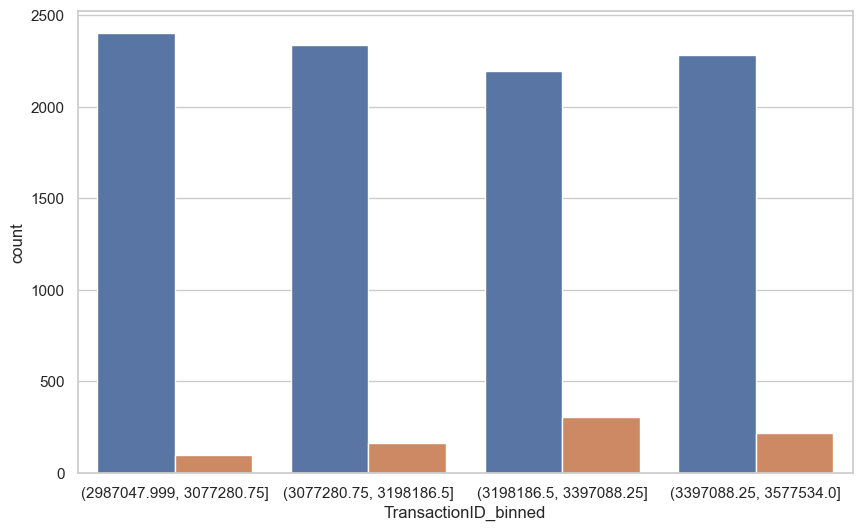

In [ ]:

# Feature Discretization and Binning
# Binning of continuous variables
for col in numerical_columns:
    df[f'{col}_binned'] = pd.qcut(df[col], q=4, duplicates='drop')
    plt.figure()
    sns.countplot(data=df, x=f'{col}_binned', hue=target_column)
    plt.title(f"Binned Distribution of {col} by Fraud Status")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:

# Feature Engineering Impact Analysis
# Check if engineered features improve model performance by adding interaction terms
df['transaction_amount_x_customer_age'] = df['transaction_amount'] * df['customer_age']
feature_importance_eng = pd.Series(mutual_info_classif(df.drop(columns=target_column), y), index=df.drop(columns=target_column).columns).sort_values(ascending=False)
print("Top Engineered Features by Mutual Information:\n", feature_importance_eng.head(5))



In [ ]:
# Stability Analysis of Temporal Features (if Time-Series Data)
if timestamp_column:
    df[timestamp_column] = pd.to_datetime(df[timestamp_column])
    df['hour'] = df[timestamp_column].dt.hour
    df['day_of_week'] = df[timestamp_column].dt.dayofweek
    df['month'] = df[timestamp_column].dt.month

    # Temporal patterns
    sns.countplot(data=df, x='hour', hue=target_column)
    plt.title("Fraud by Hour of the Day")
    plt.show()
    
    sns.countplot(data=df, x='day_of_week', hue=target_column)
    plt.title("Fraud by Day of the Week")
    plt.show()

    sns.countplot(data=df, x='month', hue=target_column)
    plt.title("Fraud by Month")
    plt.show()


In [ ]:

# Model Interpretability and Feature Consistency Checks
# SHAP Analysis for interpretability
shap_explainer = shap.TreeExplainer(rf)
shap_values = shap_explainer.shap_values(X)
shap.summary_plot(shap_values[1], X, plot_type="bar")

# Partial Dependence Plot (PDP) for one top feature
shap.dependence_plot(0, shap_values[1], X, interaction_index=None)


AssertionError: Model has no `estimators_`! Have you called `model.fit`?

In [ ]:

# Cumulative Gains or Lift Analysis
# Cumulative Gains Chart
rf_probs = rf.predict_proba(X_test)[:, 1]
df_gain = pd.DataFrame({'y_true': y_test, 'y_proba': rf_probs})
df_gain = df_gain.sort_values('y_proba', ascending=False)
df_gain['cumulative_true'] = df_gain['y_true'].cumsum()
df_gain['cumulative_gain'] = df_gain['cumulative_true'] / df_gain['y_true'].sum()

plt.plot(np.arange(len(df_gain)) / len(df_gain), df_gain['cumulative_gain'])
plt.xlabel("Percentage of Sample")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gains Chart")
plt.show()

print("\nEDA complete. Proceed to further preprocessing and modeling steps.")


NameError: name 'X_test' is not defined

In [ ]:
# Data Preprocessing

In [ ]:

# Load dataset
data = pd.read_csv("your_dataset.csv")  # Replace with your file path

# Separate features and target
X = df.drop(columns=['isFraud'])  # Replace 'isFraud' with your target column name if different
y = df['isFraud']

# Handle Missing Values
# Separate numerical and categorical features
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Impute numerical features using IterativeImputer for multivariate imputation
num_imputer = IterativeImputer(random_state=0)
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

# Impute categorical features with 'Unknown' for missing values
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

# Encode Categorical Features
# Use One-Hot Encoding for low-cardinality categorical features
low_cardinality_cols = [col for col in categorical_cols if X[col].nunique() < 10]
X = pd.get_dummies(X, columns=low_cardinality_cols, drop_first=True)

# Use Target Encoding for high-cardinality categorical features
high_cardinality_cols = [col for col in categorical_cols if X[col].nunique() >= 10]
target_encoder = TargetEncoder(cols=high_cardinality_cols)
X[high_cardinality_cols] = target_encoder.fit_transform(X[high_cardinality_cols], y)

# Scale Numerical Features
# Standardize numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Apply Power Transformation (log transformation) to reduce skewness in highly skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X[numerical_cols] = power_transformer.fit_transform(X[numerical_cols])

# Dimensionality Reduction
# Apply PCA for dimensionality reduction, retain 95% of the variance
pca = PCA(n_components=0.95, random_state=0)
X_reduced = pca.fit_transform(X)

# Split the data for training and evaluation
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=0)

# The preprocessed data is now ready for model training
print("Data preprocessing complete. Shape of training data:", X_train.shape)
